In [2]:
from py_files.feature_engineering import *
from py_files.feature_selection import *
from py_files.modeling import *
from py_files.ploting import *
from py_files.apriori_clusters import *
from py_files.preprocessing import *
from py_files.initial_visualizations import *
from py_files.helping_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
cust_basket = pd.read_csv('data/customer_basket.csv')
cust_info = pd.read_csv('data/customer_info.csv')
prod_map = pd.read_excel('data/product_mapping.xlsx')

c:\Users\loure\Documents\GitHub\ML2_Project\py_files\ploting.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


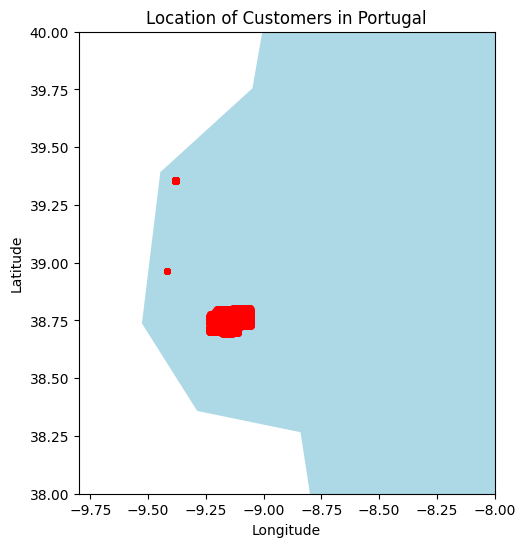

In [37]:
#para ver quais sao os pescadores, ver longitude
plot_population(cust_info)

In [38]:
find_fishermen(cust_info)['longitude'].sort_values()

TypeError: tuple indices must be integers or slices, not str

# Basci preproc to delete

For initial exploration of the clusters we need to first do some basic preprocessing: 
- alter the columns where nan values mean something
- remove nan values
- remove categorical variables
- scale data

#### Basic preprocessing explanation: 
- drop first column because it means nothing
- drop customer id, does not have business value
- drop customer name, categorical
- since bools vary the segmentation aggressively i will just remove gender as well
- i will not waste time converting birth date to age so will drop as well
- loyalty_card_number should be converted to a boolean but i will just remove it
- since latitude and longitude do not make sense to standardize and need to be analysed apart i will remove it 

In [57]:
cust_info = pd.read_csv('data/customer_info.csv')
cust_info, fishermen = find_fishermen(cust_info)

In [58]:
#cust_info, good_fellas=find_outliers(cust_info, "lifetime_spend_alcohol_drinks",2)
#good_fellas.sort_values('lifetime_spend_alcohol_drinks', ascending=False)

In [59]:
cust_info_pp = cust_info.drop(columns=['Unnamed: 0', 'customer_id', 'customer_name', 'customer_gender',
                                       'customer_birthdate', 'loyalty_card_number', 'latitude'])

In [60]:
#cust_info_pp.info()

In [61]:
#cust_info_pp.dropna(inplace=True)

imputation(cust_info_pp, cust_info_pp.select_dtypes(include=[np.number]).columns)

In [62]:
#cust_info_pp.info()

In [63]:
scaling(cust_info_pp, cust_info_pp.select_dtypes(include=[np.number]).columns)

## Kmeans Clustering

In [64]:
dispersion = create_dispersion_list(cust_info_pp)

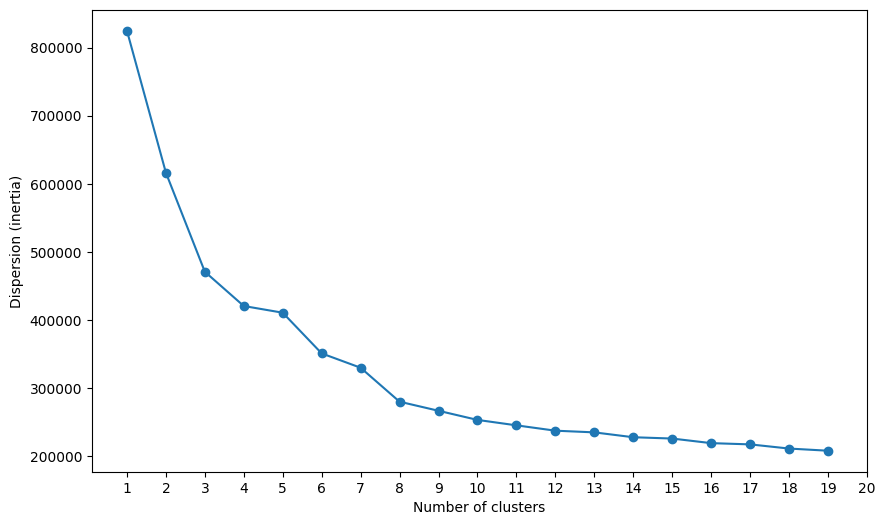

In [65]:
plot_elbow_graph(dispersion)

In this case, observing the elbow graph, we see that the dispersion decreases rapidly initially and then starts to level off. The point where this leveling off occurs, often resembling an elbow, suggests the optimal number of clusters. In the given graph, 8 seems to be a reasonable number of clusters as it corresponds to the point where the decrease in dispersion significantly slows down, indicating diminishing returns in clustering quality beyond this point. Therefore, based on the elbow method, 8 clusters appear to be a suitable choice for this dataset.

In [66]:
# allocate_clusters(cust_info_pp, cust_info_pp_sc, n_clusters=8, cluster_type='KMeans')
allocate_clusters_kmeans(cust_info, cust_info_pp, n_clusters=15)

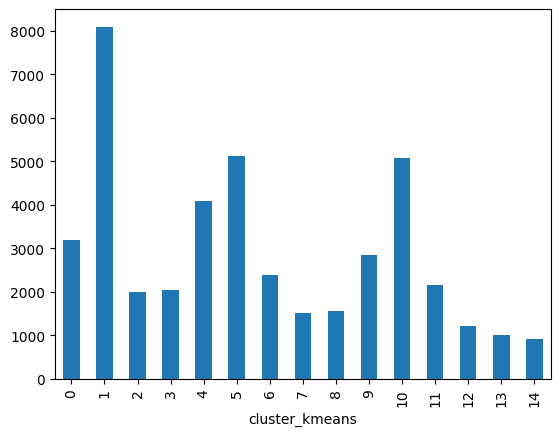

In [68]:
cust_info.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

In [73]:
def print_clusters_vs_overall_mean(data, cluster_column, cluster_numbers):
    """
    Function to print the means of the specified clusters side by side with the mean of the entire dataset,
    along with the sizes of the clusters and the dataset.

    Parameters:
    - data: DataFrame containing the data.
    - cluster_column: Name of the column containing the cluster assignments.
    - cluster_numbers: List of cluster numbers to compare against the overall mean.
    """
    # Ensure the cluster column exists in the DataFrame
    if cluster_column not in data.columns:
        print(f"Column '{cluster_column}' not found in the DataFrame.")
        return

    # Calculate the overall mean
    overall_mean = data[data.select_dtypes(include=[np.number]).columns].mean()

    # Initialize the comparison DataFrame with the overall mean
    comparison_df = pd.DataFrame({
        'Overall Mean': overall_mean
    })

    # Calculate and add the means of the specified clusters to the comparison DataFrame
    for cluster_number in cluster_numbers:
        cluster_data = data[data[cluster_column] == cluster_number]
        cluster_mean = cluster_data[cluster_data.select_dtypes(include=[np.number]).columns].mean()
        comparison_df[f'Cluster {cluster_number} Mean'] = cluster_mean

        # Print cluster size
        cluster_size = cluster_data.shape[0]
        print(f"Cluster {cluster_number} size: {cluster_size}")

    # Print overall dataset size
    overall_size = data.shape[0]
    print(f"Overall dataset size: {overall_size}")

    # Print the comparison DataFrame
    return comparison_df

print_clusters_vs_overall_mean(cust_info, 'cluster_kmeans', cluster_numbers=[12,13,14])

Cluster 12 size: 1209
Cluster 13 size: 1017
Cluster 14 size: 926
Overall dataset size: 43243


,Overall Mean,Cluster 12 Mean,Cluster 13 Mean,Cluster 14 Mean
Unnamed: 0,21809.415628,21766.777502,21008.586037,21444.419006
customer_id,24994.158315,24827.358147,24835.705015,25224.452484
kids_home,1.090720,1.001667,0.331014,0.998907
teens_home,0.855255,0.994088,0.033199,0.994475
number_complaints,0.707508,0.511335,0.027054,0.474033
distinct_stores_visited,1.675948,1.422392,1.398185,1.400221
lifetime_spend_groceries,5525.965150,13852.457403,914.469027,14095.236501
lifetime_spend_electronics,2016.323474,13482.062035,499.215339,7967.446004
typical_hour,13.552092,13.752373,18.772541,13.840807
lifetime_spend_vegetables,457.354588,502.947458,104.494516,493.898455


In [74]:
good_fellas = cust_info[cust_info['cluster_kmeans'] == 13]
cust_info_pp=cust_info_pp[cust_info['cluster_kmeans'] != 13]
cust_info=cust_info[cust_info['cluster_kmeans'] != 13]


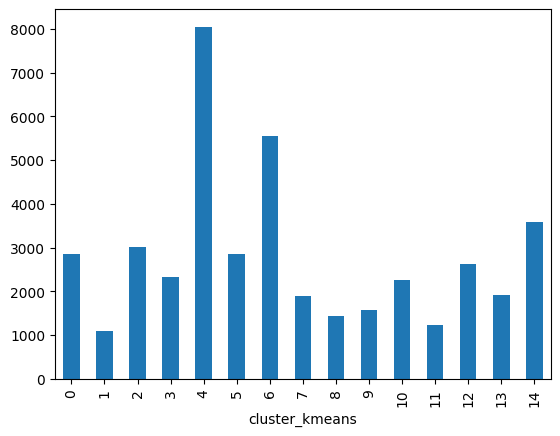

In [75]:
allocate_clusters_kmeans(cust_info, cust_info_pp, n_clusters=15)
cust_info.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()


In [76]:
print_clusters_vs_overall_mean(cust_info, 'cluster_kmeans', cluster_numbers=[1,11])

Cluster 1 size: 1093
Cluster 11 size: 1224
Overall dataset size: 42226


,Overall Mean,Cluster 1 Mean,Cluster 11 Mean
Unnamed: 0,21828.703358,21980.614822,21437.861928
customer_id,24997.974613,24833.324794,24757.934641
kids_home,1.109039,0.000000,0.000000
teens_home,0.875073,0.010300,0.014131
number_complaints,0.723833,0.510280,0.493827
distinct_stores_visited,1.682676,1.000000,1.000000
lifetime_spend_groceries,5637.031592,9856.315645,10193.133170
lifetime_spend_electronics,2052.862549,163.364135,157.831699
typical_hour,13.426401,11.824478,11.972789
lifetime_spend_vegetables,465.908926,198.204120,198.776667


In [25]:
cust_info_pp.mean()

kids_home                                     1.080386
teens_home                                    0.847899
number_complaints                             0.705042
distinct_stores_visited                       1.674720
lifetime_spend_groceries                   5597.671011
lifetime_spend_electronics                 1999.306929
typical_hour                                 13.515338
lifetime_spend_vegetables                   456.573037
lifetime_spend_nonalcohol_drinks            443.777466
lifetime_spend_alcohol_drinks               496.149047
lifetime_spend_meat                         709.645952
lifetime_spend_fish                        1474.895754
lifetime_spend_hygiene                      917.655878
lifetime_spend_videogames                   990.666458
lifetime_spend_petfood                     2017.580236
lifetime_total_distinct_products            387.235732
percentage_of_products_bought_promotion       0.229844
year_first_transaction                     2011.349494
cluster_km

Note: It is **very** important to compare clusters against the mean of the variables and not their relative difference in between clusters. The mean (or any other centrality measure) of the variable will give us an "anchor" that we can use when explaining why a certain "cluster" has a certain set of characteristics.

## Hierarchical Clustering

In [ ]:
# por isto em funcao 
# agg_clust = create_agg_clusters(cust_info_pp_sc)
agg_clust = create_agg_clusters(sample_pp_sc)

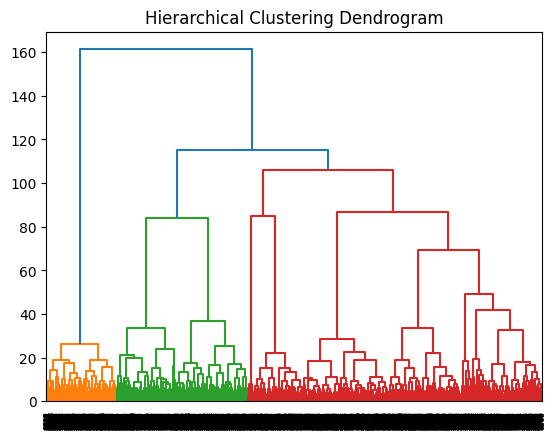

In [ ]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.show()

We can notice that outliers are still present in the dataset because some clusters have very few points.

On the right clusters should be further analysed in order to understand if they are similiar (if so join in one) or different (mantain separate)

I will cut around the y=200 making the solution 8 clusters to be able to compare it with the k-means.

In [ ]:
# allocate_clusters(cust_info_pp, cust_info_pp_sc, n_clusters=8, cluster_type='AgglomerativeClustering')
allocate_clusters_aggclust(sample_pp, sample_pp_sc, n_clusters=8)

In [ ]:
AgglomerativeClustering()

AgglomerativeClustering()

In [ ]:
# cust_info_pp.head()
sample_pp.head()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cluster_kmeans,cluster_hierarchical
32174,1.0,0.0,1.0,1.0,3932.0,332.0,9.0,149.0,812.0,1575.0,725.0,2079.0,1924.0,869.0,1560.0,1608.0,0.195728,2010.0,4,2
24009,2.0,1.0,1.0,2.0,4454.0,3148.0,18.0,462.0,551.0,445.0,1192.0,1187.0,678.0,1090.0,1056.0,82.0,0.151540,2007.0,3,1
38186,1.0,1.0,0.0,2.0,892.0,549.0,17.0,904.0,870.0,910.0,744.0,499.0,300.0,521.0,514.0,41.0,-0.100004,2007.0,0,0
27250,1.0,1.0,1.0,3.0,2003.0,272.0,15.0,233.0,264.0,175.0,601.0,339.0,358.0,526.0,928.0,339.0,0.594341,2016.0,2,3
30806,1.0,0.0,1.0,1.0,2738.0,689.0,11.0,1249.0,250.0,9.0,1.0,0.0,417.0,238.0,597.0,226.0,0.193813,2012.0,0,4


In [ ]:
# cust_info_pp.groupby(['cluster_hierarchical']).mean()
sample_pp.groupby(['cluster_hierarchical']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cluster_kmeans
cluster_hierarchical,,,,,,,,,,,,,,,,,,,
0,0.510851,0.480801,0.337229,1.782972,2728.519199,1486.824708,14.380634,315.799666,429.242070,712.545910,523.803005,607.272120,548.754591,597.818030,557.343907,375.165275,0.191901,2014.429048,5.148581
1,3.139665,1.983240,0.951583,1.098696,5073.864060,1981.644320,17.677840,496.728119,509.182495,302.350093,1040.962756,1020.100559,988.251397,1016.668529,1003.184358,502.452514,0.200029,2011.048417,3.078212
2,1.046296,0.835648,1.111111,1.962963,4944.481481,2062.432870,9.592593,309.995370,588.738426,1002.932870,972.039352,1876.958333,1910.650463,960.138889,1893.287037,992.261574,0.201740,2008.625000,4.002315
3,0.559041,0.987085,0.998155,3.149446,2053.488930,216.136531,12.378229,208.105166,308.990775,307.081181,409.470480,498.055351,487.448339,385.202952,602.964945,396.435424,0.525052,2010.976015,2.009225
4,1.000000,0.450479,0.533546,1.177316,2967.186901,419.099042,13.686901,992.530351,302.132588,141.642173,48.031949,39.731629,518.049521,219.798722,506.105431,209.774760,0.206555,2011.105431,0.059105
5,0.000000,0.083333,0.583333,1.000000,13912.722222,184.138889,10.444444,356.694444,310.666667,96.222222,102.472222,40073.722222,91.527778,0.000000,0.000000,20.583333,0.388960,2011.250000,6.000000
6,0.000000,0.016216,0.470270,1.000000,9941.762162,158.386486,11.902703,195.086486,503.748649,40.305405,196.156757,211.740541,75.586486,0.000000,9917.137838,50.859459,0.195328,2011.070270,5.005405
7,1.001905,1.000000,0.499048,1.432381,13873.830476,8094.043810,13.580952,490.954286,598.548571,1038.327619,1990.000000,4008.569524,1991.780952,3975.758095,2981.209524,101.333333,0.042105,2011.205714,1.000000


In [ ]:
# cust_info_pp.mean()
sample_pp.mean()

kids_home                                     1.063267
teens_home                                    0.835833
number_complaints                             0.688574
distinct_stores_visited                       1.665667
lifetime_spend_groceries                   5707.277066
lifetime_spend_electronics                 2056.130079
typical_hour                                 13.481865
lifetime_spend_vegetables                   454.517589
lifetime_spend_nonalcohol_drinks            450.858740
lifetime_spend_alcohol_drinks               502.058631
lifetime_spend_meat                         726.941369
lifetime_spend_fish                        1538.781293
lifetime_spend_hygiene                      913.618489
lifetime_spend_videogames                  1023.308154
lifetime_spend_petfood                     2063.966185
lifetime_total_distinct_products            366.005999
percentage_of_products_bought_promotion       0.226827
year_first_transaction                     2011.340878
cluster_km

In [ ]:
# Starting with the Ward vs. k-means:
'''pd.DataFrame(
    confusion_matrix(cust_info_pp.cluster_kmeans, cust_info_pp.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,8)],
    columns = ['Ward {} Cluster'.format(i) for i in np.arange(0,8)],
)'''
pd.DataFrame(
    confusion_matrix(sample_pp.cluster_kmeans, sample_pp.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,8)],
    columns = ['Ward {} Cluster'.format(i) for i in np.arange(0,8)],
)

,Ward 0 Cluster,Ward 1 Cluster,Ward 2 Cluster,Ward 3 Cluster,Ward 4 Cluster,Ward 5 Cluster,Ward 6 Cluster,Ward 7 Cluster
K-means 0 Cluster,48,5,3,0,620,0,0,0
K-means 1 Cluster,0,0,0,0,0,0,0,525
K-means 2 Cluster,133,0,5,541,1,0,0,0
K-means 3 Cluster,12,514,4,0,0,0,0,0
K-means 4 Cluster,20,5,411,0,0,0,0,0
K-means 5 Cluster,0,0,0,0,0,0,369,0
K-means 6 Cluster,0,0,0,0,0,36,0,0
K-means 7 Cluster,386,13,9,1,5,0,1,0


We can see some similarities within clusters:
- Cluster 0 in kmeans is very simmilar to cluster 4 in hierarchical
- Cluster 1 in kmeans is simmilar to cluster 3 in hierarchical
- Cluster 2 in kmeans is simmilar to cluster 3 in hierarchical
- Cluster 3 in kmeans is very dispersed (divided into 1, 2 and 6)
- Cluster 4 in kmeans is divided into cluster 3 and 4 from hierachical
- Cluster 5 in kmeans is divided into cluster 0 and 7 from hierachical
- Cluster 6 in kmeans is very simmilar to cluster 4 in hierarchical
- Cluster 7 in kmeans only has values from cluster 5 in hierarchical but only 330 records

In [ ]:
cust_basket

,invoice_id,list_of_goods,customer_id
0,7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
1,3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
2,10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134
3,12179179,"['babies food', 'milk', 'rice', 'yogurt cake',...",43134
4,8292388,"['napkins', 'cookies', 'razor', 'cooking oil',...",43134
...,...,...,...
89947,10920856,"['rice', 'pet food', 'cauliflower', 'cake', 'c...",31335
89948,10239983,"['cotton buds', 'cream', 'gums', 'cooking oil'...",35452
89949,10238942,"['cottage cheese', 'champagne', 'spaghetti', '...",3608
89950,6593522,"['chutney', 'samsung galaxy 10', 'catfish', 't...",33063


In [ ]:
cust_info

,Unnamed: 0,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,0,39634,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
1,1,43460,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
2,2,23937,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105
3,3,2431,Ora Boggess,female,06/15/1941 03:26 AM,0.0,0.0,0.0,1.0,10825.0,...,151.0,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318
4,4,10090,Lonnie Hopson,male,12/18/2001 03:03 AM,0.0,0.0,0.0,1.0,697.0,...,172.0,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43626,43626,48487,Amelia Crawford,female,08/28/1983 11:43 AM,1.0,1.0,0.0,1.0,7189.0,...,3779.0,1748.0,4387.0,2812.0,14.0,0.233259,2016.0,NaN,38.760694,-9.166146
43627,43627,24856,Silvia Ramos,female,09/21/1992 07:16 PM,1.0,1.0,1.0,1.0,11238.0,...,3893.0,1621.0,3831.0,2726.0,25.0,0.060977,2014.0,909859.0,38.760280,-9.166643
43628,43628,21373,Addie Coronel,female,02/20/1994 05:58 AM,0.0,0.0,0.0,1.0,6059.0,...,142.0,179.0,0.0,11242.0,44.0,0.097672,2017.0,NaN,38.769923,-9.181550
43629,43629,19527,Msc. Mary Ross,female,08/06/1989 04:39 PM,1.0,0.0,1.0,1.0,3098.0,...,0.0,393.0,210.0,422.0,178.0,0.182188,2007.0,933102.0,38.760889,-9.174663


In [ ]:
prod_map

,product_name,category
0,champagne,alcohol_drinks
1,bramble,alcohol_drinks
2,white wine,alcohol_drinks
3,dessert wine,alcohol_drinks
4,french wine,alcohol_drinks
...,...,...
160,final fantasy XX,videogames
161,final fantasy XIX,videogames
162,final fantasy XXII,videogames
163,dog food,pet food


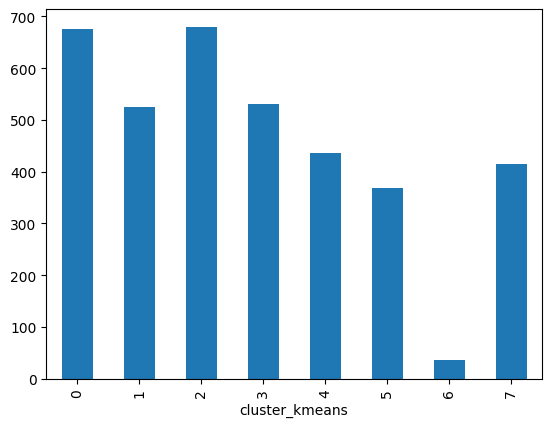

In [ ]:
sample_pp.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

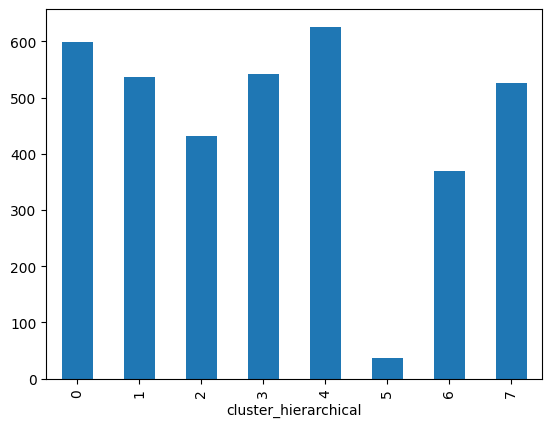

In [ ]:
sample_pp.groupby(['cluster_hierarchical']).size().plot(kind='bar')
plt.show()

In [ ]:
eps_values = np.arange(0.1, 1.1, 0.1)
min_samples_values = range(2, 11)

# ITERATE CLUSTERS TO DEFINE THE BEST PARAMS

for min_samples_test in min_samples_values:
    for eps_test in eps_values:
        '''model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit_predict(data_preprocessed)'''
        pass

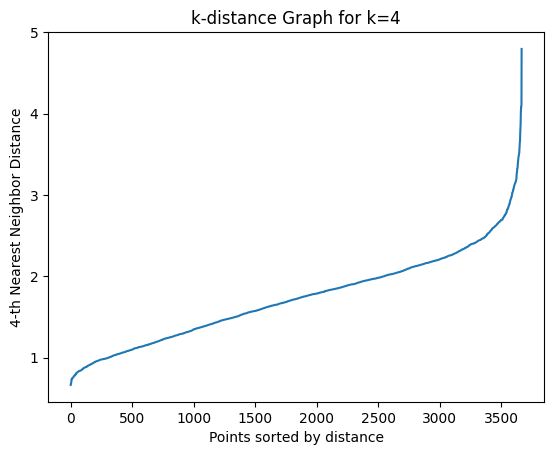

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'k-distance Graph for k={k}')
    plt.show()

# Plot the k-distance graph
plot_k_distance(sample_pp_sc, k=4)

In [ ]:
from scipy.spatial import distance_matrix

# Calculate the distance matrix
dist_matrix = distance_matrix(sample_pp_sc, sample_pp_sc)

# Summary statistics of pairwise distances
print('Min distance:', np.min(dist_matrix))
print('Max distance:', np.max(dist_matrix))
print('Mean distance:', np.mean(dist_matrix))
print('Median distance:', np.median(dist_matrix))

Min distance: 0.0
Max distance: 17.37207960341201
Mean distance: 5.74037033024711
Median distance: 5.670100225062141


In [ ]:
sample_pp_sc.shape

(3667, 18)

In [ ]:
3667 * 0.15

550.05

In [ ]:
eps_range = np.arange(1, 2.5, 0.1)
min_samples_range = range(5, 13)

# Function to calculate and print cluster sizes and noise points
def print_cluster_info(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_info = dict(zip(unique_labels, counts))
    
    noise_points = cluster_info.get(-1, 0)
    clusters = {k: v for k, v in cluster_info.items() if k != -1}
    
    return clusters, noise_points

# Grid search over the parameter ranges
for min_samples in min_samples_range:
    for eps_val in eps_range:
        model = DBSCAN(eps=eps_val, min_samples=min_samples)
        labels = model.fit_predict(sample_pp_sc)
        
        clusters, noise_points = print_cluster_info(labels)
        
        if noise_points <= 500:
            print(f'eps: {round(eps_val,2)}, min_samples: {min_samples}')
            print(f'Cluster sizes: {clusters}')
            print(f'Number of noise points: {noise_points}')
            print('-' * 40)

eps: 2.2, min_samples: 5
Cluster sizes: {0: 2753, 1: 454, 2: 21, 3: 7}
Number of noise points: 432
----------------------------------------
eps: 2.3, min_samples: 5
Cluster sizes: {0: 2839, 1: 480, 2: 30}
Number of noise points: 318
----------------------------------------
eps: 2.4, min_samples: 5
Cluster sizes: {0: 2925, 1: 496, 2: 31}
Number of noise points: 215
----------------------------------------
eps: 2.2, min_samples: 6
Cluster sizes: {0: 2737, 1: 448, 2: 20}
Number of noise points: 462
----------------------------------------
eps: 2.3, min_samples: 6
Cluster sizes: {0: 2826, 1: 476, 2: 22, 3: 5}
Number of noise points: 338
----------------------------------------
eps: 2.4, min_samples: 6
Cluster sizes: {0: 2914, 1: 494, 2: 29}
Number of noise points: 230
----------------------------------------
eps: 2.2, min_samples: 7
Cluster sizes: {0: 2721, 1: 442, 2: 20, 3: 4}
Number of noise points: 480
----------------------------------------
eps: 2.3, min_samples: 7
Cluster sizes: {0: 

In [ ]:
allocate_clusters_dbscan(sample_pp, sample_pp_sc, eps=2.5, min_samples=8)

sample_pp.groupby(['cluster_dbscan']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cluster_kmeans,cluster_hierarchical
cluster_dbscan,,,,,,,,,,,,,,,,,,,,
-1,1.236559,0.962366,0.833333,2.037634,4941.854839,2146.817204,13.075269,511.908602,679.602151,924.666667,911.037634,2669.139785,1104.177419,1114.446237,1187.715054,638.408602,0.158872,2012.768817,3.430108,2.059140
0,1.073848,0.807588,0.711721,1.698171,4290.093157,1058.671748,13.529810,446.216463,413.514566,388.566734,508.052846,661.735772,727.970867,528.115176,1985.141599,397.160230,0.260391,2011.302846,3.004065,2.567751
1,1.000000,1.000000,0.501002,1.374749,13885.981964,8034.965932,13.575150,491.533066,595.575150,1040.058116,1991.112224,4012.180361,1989.967936,3980.336673,2980.983968,101.018036,0.043257,2011.060120,1.000000,7.000000
2,0.000000,0.100000,0.633333,1.000000,13864.666667,195.800000,9.733333,299.833333,300.200000,100.766667,96.800000,39690.966667,96.600000,0.000000,0.000000,19.166667,0.398868,2010.900000,6.000000,5.000000


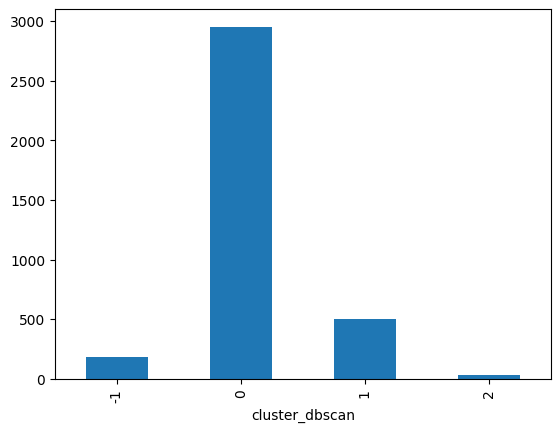

In [ ]:
sample_pp.groupby(['cluster_dbscan']).size().plot(kind='bar')
plt.show()

In [ ]:
from sklearn.cluster import estimate_bandwidth

estimate_bandwidth(sample_pp_sc, quantile=0.15)

In [ ]:
allocate_clusters_meanshift(sample_pp, sample_pp_sc, bandwidth=4)

In [ ]:
sample_pp.groupby(['cluster_meanshift']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cluster_kmeans,cluster_hierarchical,cluster_dbscan
cluster_meanshift,,,,,,,,,,,,,,,,,,,,,
0,1.232189,0.923588,0.740495,1.805463,3442.671835,1166.573643,13.735327,485.748985,415.953858,455.816537,...,729.288298,820.172388,606.437062,847.533038,461.510520,0.264720,2011.435216,2.765965,2.023256,-0.050941
1,1.005576,1.000000,0.507435,1.453532,13684.988848,7981.836431,13.485130,486.819703,603.055762,1045.784387,...,3960.280669,2001.189591,3904.314126,2957.689591,115.159851,0.044620,2011.122677,1.072491,6.879182,0.873606
2,0.000000,0.016260,0.471545,1.000000,9956.149051,158.647696,11.907859,195.065041,503.642276,40.070461,...,212.102981,75.452575,0.000000,9936.764228,50.848238,0.195482,2011.048780,5.000000,6.000000,0.000000
3,0.000000,0.083333,0.583333,1.000000,13912.722222,184.138889,10.444444,356.694444,310.666667,96.222222,...,40073.722222,91.527778,0.000000,0.000000,20.583333,0.388960,2011.250000,6.000000,5.000000,1.500000
4,1.333333,1.066667,3.400000,2.000000,4345.733333,1345.533333,13.600000,272.866667,333.866667,1690.666667,...,1034.533333,1374.333333,607.466667,979.600000,696.800000,0.300583,2009.533333,3.600000,2.000000,-0.866667


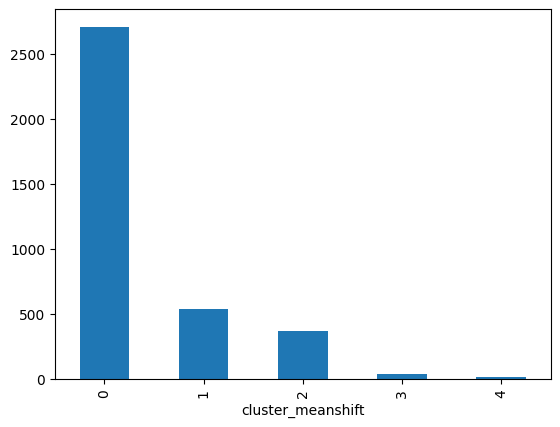

In [ ]:
sample_pp.groupby(['cluster_meanshift']).size().plot(kind='bar')
plt.show()